<a href="https://colab.research.google.com/github/pritam-banik-roy/Multi_step_forcasting_Price_data/blob/main/Multi_step_forcasting_Price_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import all necessaray packages


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import os

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense,Dropout, GRU
from tensorflow.keras.regularizers import L2
from keras.utils import plot_model
from tensorflow.keras.models import load_model

##Connect to drive for import datasets


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import google.colab.auth

##Make a datafame

In [ ]:
#folder path
folder_path = '/content/drive/MyDrive/WB_Rice/variety_13-23'

In [ ]:
#make a data frame which contains all excel files and indexing all files by market name and varity names
#varaity_no and market_no are the unique number to identify the excel files acually they are composite key
#acually this df is like a index book of all excel files
index =[]
market_no = []
variety_no = []
market =[]
variety = []
file_name =[]
for file in os.listdir(folder_path):
  index.append(str(file.split('_')[0])+'_'+str(file.split('_')[1]))
  market_no.append(int(file.split('_')[0]))
  variety_no.append(int(file.split('_')[1]))
  market.append(str(file.split('_')[5]))
  variety.append(str(file.split('_')[6]).replace('.xlsx', ''))
  file_name.append(file)

In [ ]:
df = pd.DataFrame({'index':index,
                   'market_no':market_no,
                   'variety_no':variety_no,
                   'market':market,
                   'variety':variety,
                   'file':file_name})

In [ ]:
df = df.sort_values(by=['market_no'], ascending=True)
df.head()

,index,market_no,variety_no,market,variety,file
0,0_1,0,1,Alipurduar,Common,0_1_WB_rice_market_Alipurduar_Common.xlsx
186,0_0,0,0,Alipurduar,Fine,0_0_WB_rice_market_Alipurduar_Fine.xlsx
187,0_4,0,4,Alipurduar,Other,0_4_WB_rice_market_Alipurduar_Other.xlsx
2,0_2,0,2,Alipurduar,Super Fine,0_2_WB_rice_market_Alipurduar_Super Fine.xlsx
1,0_3,0,3,Alipurduar,Fine(Basmati),0_3_WB_rice_market_Alipurduar_Fine(Basmati).xlsx


In [ ]:
#extract a file from df [ for demo purpose ]
file_name = df['file'].iloc[39]
file_path = os.path.join(folder_path, file_name)
data = pd.read_excel(file_path)
data.head()

,Unnamed: 0,Sl no.,District Name,Market Name,Commodity,Variety,Grade,Min Price (Rs./Quintal),Max Price (Rs./Quintal),Modal Price (Rs./Quintal),Price Date
0,9197,9198,Burdwan,Burdwan,Rice,Fine,FAQ,2230,2270,2250,2014-12-31
1,9198,9199,Burdwan,Burdwan,Rice,Fine,FAQ,2230,2270,2250,2014-12-30
2,9201,9202,Burdwan,Burdwan,Rice,Fine,FAQ,2230,2270,2250,2014-12-29
3,9202,9203,Burdwan,Burdwan,Rice,Fine,FAQ,2230,2270,2250,2014-12-28
4,9205,9206,Burdwan,Burdwan,Rice,Fine,FAQ,2230,2270,2250,2014-12-27


In [ ]:
df

,index,market_no,variety_no,market,variety,file
0,0_1,0,1,Alipurduar,Common,0_1_WB_rice_market_Alipurduar_Common.xlsx
186,0_0,0,0,Alipurduar,Fine,0_0_WB_rice_market_Alipurduar_Fine.xlsx
187,0_4,0,4,Alipurduar,Other,0_4_WB_rice_market_Alipurduar_Other.xlsx
2,0_2,0,2,Alipurduar,Super Fine,0_2_WB_rice_market_Alipurduar_Super Fine.xlsx
1,0_3,0,3,Alipurduar,Fine(Basmati),0_3_WB_rice_market_Alipurduar_Fine(Basmati).xlsx
...,...,...,...,...,...,...
179,82_1,82,1,Gangarampur(Dakshin Dinajpur),Common,82_1_WB_rice_market_Gangarampur(Dakshin Dinajp...
182,83_0,83,0,Kolaghat,Fine,83_0_WB_rice_market_Kolaghat_Fine.xlsx
183,83_1,83,1,Kolaghat,Common,83_1_WB_rice_market_Kolaghat_Common.xlsx
184,84_3,84,3,Siliguri,Fine(Basmati),84_3_WB_rice_market_Siliguri_Fine(Basmati).xlsx


In [ ]:
#total length of the df
length  = df.shape[0]

##Outlier analysis

Acually it is not necessary for time sequence data

In [ ]:
#finding IQR
def find_iqr(data):
  percentile25 = pd.Series(data).quantile(0.25)
  percentile75 = pd.Series(data).quantile(0.75)
  iqr = percentile75 - percentile25
  upper_limit = percentile75 + 1.5*iqr
  lower_limit = percentile25 - 1.5*iqr

  return upper_limit, lower_limit

In [ ]:
def outlier( data , upper , lower):
  outlier_1 = data[data > upper]
  outlier_2 = data[data < lower]
  return outlier_1, outlier_2

In [ ]:
def remove_outliers(data, upper_limit, lower_limit):
  new_data = []
  for value in data:
    if value <= upper_limit and value >= lower_limit:
      new_data.append(value)
  return new_data

##Write funtions for make the sequence data devide into input and output
 There are 3 sequence data in each excel file --> minimum price , maximum price and model price



 our aim is the predict all three prices for a perticular market and a particular variety of rice. for that we need to divide the minimum price , maximum price and model price into input , output sequence indiviually


 for an example for minimum price data(array) first 60 data in input and next data 61th data is output in this way second 60 data is input and 61th data is output. in this way the whole array will cover this sequence and devide into input and output.


 This process will continoue for Maximum price data and Modal price data

 After that convert them into numpy.array

 Then apply MinmaxScaler from keras library

In [ ]:
def create_sequence(data):
  x = []
  y = []
  seq = 45
  for i in range(seq, len(data)):
      x.append(data[i-seq:i])
      y.append(data[i])

  return np.array(x), np.array(y)

In [ ]:
def apply_minmax_scaler(x_data , y_data ):

  sc = MinMaxScaler(feature_range=(0, 1))

  x_scaled = sc.fit_transform(x_data)
  y_scaled = sc.fit_transform(y_data)

  return x_scaled , y_scaled

#Make the LSTM model

make 3 LSTM models for min, max , mod price and append this 3 models into a list


In [ ]:
# create 3 Model for Min price , Max price , Mod Price and add those models to a list

models = []
for i in range(3):
  #input layer
  model = Sequential()

  model.add(Embedding(2,150, input_length = 45))
  #Hidden Layer -1
  model.add(LSTM(units=150,return_sequences=True, kernel_regularizer = L2(0.01)))
  model.add(Dropout(0.2))

  #Hidden Layer -2
  model.add(LSTM(units=50, kernel_regularizer = L2(0.01)))
  model.add(Dropout(0.2))

  #Output Layer
  # model.add(Dense(50 , activation ='relu', kernel_regularizer = L2(0.01)))
  model.add(Dense(1 , kernel_regularizer = L2(0.01)))
  model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics = ['accuracy'])
  models.append(model)

In [ ]:
#model Summary of this three models

for i, model in enumerate(models):
  if i == 0:
    print("model[0] summary -->")
    print(models[0].summary())
  if i == 1:
    print("model[1] summary -->")
    print(models[1].summary())
  else:
    print("model[2] summary -->")
    print(models[2].summary())

model[0] summary -->
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 45, 150)           300       
                                                                 
 lstm (LSTM)                 (None, 45, 150)           180600    
                                                                 
 dropout (Dropout)           (None, 45, 150)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                40200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 221151 (863.87 KB)
Tr

##Train the models for all the datas
there are 188 files and each files have 3 types of price data present so
there should be 188*3 = 556 models

each models are giveing index by variety type, market name and price data. so, in this way each and every market is diffient from each other  

In [ ]:
#create a dictionary to map market name and market no
market_dict = {}
for i in range(df.shape[0]):
  market_dict[df['market'].iloc[i]] = df['market_no'].iloc[i]

#create a dictionary to map variety name and variety no
variety_dict = {}
for i in range(df.shape[0]):
  variety_dict[df['variety'].iloc[i]] = df['variety_no'].iloc[i]

def find_market_no(market_name):
  return market_dict[market_name]

def find_variety_no(variety_name):
  return variety_dict[variety_name]

In [ ]:
variety_dict

{'Common': 1,
 'Fine': 0,
 'Other': 4,
 'Super Fine': 2,
 'Fine(Basmati)': 3,
 'Masuri': 5,
 'Ratnachudi (718 5-749)': 7,
 'Sona Mansoori Non Basmati': 8,
 'H.Y.V.': 9,
 'Coarse': 6,
 'Sona Coarse': 10,
 'Parimal (New)': 11,
 'Coarse (I.R.20)': 14,
 'Sona': 15,
 'Boiled Rice': 19}

In [ ]:
# prompt: make a different database which only contains market name and market no which contains unique value

unique_market_df = df[['market', 'market_no']].drop_duplicates()

In [ ]:
unique_market_df

,market,market_no
0,Alipurduar,0
7,Asansol,1
4,Balurghat,2
5,Bankura Sadar,3
12,Barasat,4
...,...,...
178,Balarampur,80
181,Falakata,81
179,Gangarampur(Dakshin Dinajpur),82
182,Kolaghat,83


In [ ]:
# prompt: download unique_market_df as .csv
folder_path = '/content/drive/MyDrive/WB_Rice'

unique_market_df.to_csv('unique_market_df.csv', index=False)
file_name = 'unique_market_df.csv'
file_path = os.path.join(folder_path , file_name)
files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
market_dict

{'Alipurduar': 0,
 'Asansol': 1,
 'Balurghat': 2,
 'Bankura Sadar': 3,
 'Barasat': 4,
 'Baruipur(Canning)': 5,
 'Baxirhat': 6,
 'Belacoba': 7,
 'Beldanga': 8,
 'Bethuadahari': 9,
 'Birbhum': 10,
 'Bishnupur(Bankura)': 12,
 'Bolpur': 13,
 'Burdwan': 14,
 'Chakdah': 15,
 'Champadanga': 16,
 'Coochbehar': 18,
 'Darjeeling': 19,
 'Darjeeling(Klimpong)': 20,
 'Diamond Harbour': 21,
 'Diamond Harbour(South 24-pgs)': 22,
 'Dinhata': 23,
 'Durgapur': 24,
 'English Bazar': 26,
 'Falakata(Dhupguri)': 27,
 'Gajol': 28,
 'Gangarampur': 29,
 'Garbeta(Medinipur)': 30,
 'Ghatal': 31,
 'Guskara': 32,
 'Guskara(Burdwan)': 33,
 'Habra': 34,
 'Haldibari': 35,
 'Indus': 36,
 'Indus(Bankura Sadar)': 37,
 'Islampur': 38,
 'Jalpaiguri Sadar': 39,
 'Jangipur': 40,
 'Jhargram': 41,
 'Jiaganj': 42,
 'Jiaganj(Lalbagh)': 43,
 'Kaliaganj': 44,
 'Kalimpong': 45,
 'Kalipur': 46,
 'Kalipur(Champadanga)': 47,
 'Kalna': 48,
 'Kalyani': 49,
 'Kandi': 50,
 'Karimpur': 51,
 'Karsiyang(Matigara)': 52,
 'Kasimbazar': 53,
 '

In [ ]:
# prompt: list all the market name in list

market_names = []
for i in range(df.shape[0]):
  market_names.append(df['market'].iloc[i])
print(market_names)


['Alipurduar', 'Alipurduar', 'Alipurduar', 'Alipurduar', 'Alipurduar', 'Asansol', 'Asansol', 'Balurghat', 'Balurghat', 'Balurghat', 'Bankura Sadar', 'Bankura Sadar', 'Barasat', 'Barasat', 'Barasat', 'Barasat', 'Baruipur(Canning)', 'Baruipur(Canning)', 'Baruipur(Canning)', 'Baxirhat', 'Baxirhat', 'Baxirhat', 'Baxirhat', 'Belacoba', 'Belacoba', 'Belacoba', 'Beldanga', 'Bethuadahari', 'Birbhum', 'Birbhum', 'Bishnupur(Bankura)', 'Bishnupur(Bankura)', 'Bishnupur(Bankura)', 'Bishnupur(Bankura)', 'Bolpur', 'Bolpur', 'Bolpur', 'Bolpur', 'Burdwan', 'Burdwan', 'Burdwan', 'Chakdah', 'Champadanga', 'Coochbehar', 'Coochbehar', 'Coochbehar', 'Darjeeling', 'Darjeeling(Klimpong)', 'Diamond Harbour', 'Diamond Harbour', 'Diamond Harbour(South 24-pgs)', 'Diamond Harbour(South 24-pgs)', 'Dinhata', 'Durgapur', 'Durgapur', 'English Bazar', 'English Bazar', 'English Bazar', 'Falakata(Dhupguri)', 'Falakata(Dhupguri)', 'Falakata(Dhupguri)', 'Gajol', 'Gajol', 'Gajol', 'Gajol', 'Gajol', 'Gangarampur', 'Gangaramp

In [ ]:
df

,index,market_no,variety_no,market,variety,file
0,0_1,0,1,Alipurduar,Common,0_1_WB_rice_market_Alipurduar_Common.xlsx
186,0_0,0,0,Alipurduar,Fine,0_0_WB_rice_market_Alipurduar_Fine.xlsx
187,0_4,0,4,Alipurduar,Other,0_4_WB_rice_market_Alipurduar_Other.xlsx
2,0_2,0,2,Alipurduar,Super Fine,0_2_WB_rice_market_Alipurduar_Super Fine.xlsx
1,0_3,0,3,Alipurduar,Fine(Basmati),0_3_WB_rice_market_Alipurduar_Fine(Basmati).xlsx
...,...,...,...,...,...,...
179,82_1,82,1,Gangarampur(Dakshin Dinajpur),Common,82_1_WB_rice_market_Gangarampur(Dakshin Dinajp...
182,83_0,83,0,Kolaghat,Fine,83_0_WB_rice_market_Kolaghat_Fine.xlsx
183,83_1,83,1,Kolaghat,Common,83_1_WB_rice_market_Kolaghat_Common.xlsx
184,84_3,84,3,Siliguri,Fine(Basmati),84_3_WB_rice_market_Siliguri_Fine(Basmati).xlsx


In [ ]:
length

188

Don't run this code

Train all models and save it. Then store those in a drive folder for future use

In [ ]:
model_folder_path = '/content/drive/MyDrive/WB_Rice/models'
for i in range(length):
  file_name = df['file'].iloc[i]
  file_path = os.path.join(folder_path, file_name)
  data = pd.read_excel(file_path)

  #drop unwanted column
  data.drop(data.columns[0], axis=1, inplace=True)

  #assending the data with price date
  data.sort_values(by='Price Date', inplace=True)
  data = data.reset_index(drop=True)

  #take prices as input
  price = data[['Min Price (Rs./Quintal)', 'Max Price (Rs./Quintal)', 'Modal Price (Rs./Quintal)']].values

  #seperate the maximum, minimum and modal price
  price_min = price[:,0]
  price_max = price[:,1]
  price_mod = price[:,2]

  # #remove outlier from the data
  # #--> find out upper limit and lower limit
  # price_min_upper , price_min_lower = find_iqr(price_min)
  # price_max_upper , price_max_lower = find_iqr(price_max)
  # price_mod_upper , price_mod_lower = find_iqr(price_mod)

  # #--> find out the ouliers
  # price_min_outlier_1 , price_min_outlier_2 = outlier(price_min, price_min_upper, price_min_lower)
  # price_max_outlier_1 , price_max_outlier_2 = outlier(price_max, price_max_upper, price_max_lower)
  # price_mod_outlier_1 , price_mod_outlier_2 = outlier(price_mod, price_mod_upper, price_mod_lower)

  # #--> remove outliers
  # price_min = remove_outliers(price_min, price_min_upper, price_min_lower)
  # price_max = remove_outliers(price_max, price_max_upper, price_max_lower)
  # price_mod = remove_outliers(price_mod, price_mod_upper, price_mod_lower)

  #create a sequence of of data and make x , y from the data
  price_min_x , price_min_y = create_sequence(price_min)
  price_max_x , price_max_y = create_sequence(price_max)
  price_mod_x , price_mod_y = create_sequence(price_mod)

  #reshape that data
  price_min_y = price_min_y.reshape(-1,1)
  price_max_y = price_max_y.reshape(-1,1)
  price_mod_y = price_mod_y.reshape(-1,1)

  #apply min-max scaler to the data
  price_min_x_scaled, price_min_y_scaled = apply_minmax_scaler(price_min_x, price_min_y)
  price_max_x_scaled, price_max_y_scaled = apply_minmax_scaler(price_max_x, price_max_y)
  price_mod_x_scaled, price_mod_y_scaled = apply_minmax_scaler(price_mod_x, price_mod_y)

  n = price_min_x_scaled.shape[1]


  market = str(data['Market Name'].unique())[2:-2]
  variety = str(data['Variety'].unique())[2:-2]
  market_no = find_market_no(market)
  variety_no = find_variety_no(variety)

  # Train the models
  for j, model in enumerate(models):
    if j == 0:
      print('Model[0] fits for '+market+" and "+variety+ ' and min price \n')
      models[0].fit(price_min_x_scaled, price_min_y_scaled, epochs=100, batch_size=32)
    elif j == 1:
      print('Model[1] fits for '+market+" and "+variety+ ' and max price \n')
      models[1].fit(price_max_x_scaled, price_max_y_scaled, epochs=100, batch_size=32)
    else:
      print('Model[2] fits for '+market+" and "+variety+ ' and mod price \n')
      models[2].fit(price_mod_x_scaled, price_mod_y_scaled, epochs=100, batch_size=32)

  # Save the models
  for j, model in enumerate(models):
    model.save(f'{i}_{market_no}_{variety_no}_model_{j}.h5')

  #save the models to google drive for future use
    model_path = f'{i}_{market_no}_{variety_no}_model_{j}.h5'
    model_path = os.path.join(model_folder_path, model_path)
    model.save(model_path)
  # Download the models
  # for j, model in enumerate(models):
  #   model_path = f'{i}_{market_no}_{variety_no}_model_{j}.h5'
  #   model_path = os.path.join(model_folder_path, model_path)
  #   files.download(model_path)

Model[0] fits for Falakata and Common and min price 

Epoch 1/100
49/49 [==============================] - 1s 11ms/step - loss: 0.0457 - accuracy: 0.0019
Epoch 2/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0369 - accuracy: 0.0026
Epoch 3/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0370 - accuracy: 0.0026
Epoch 4/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0358 - accuracy: 0.0026
Epoch 5/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0361 - accuracy: 0.0026
Epoch 6/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0360 - accuracy: 0.0026
Epoch 7/100
49/49 [==============================] - 1s 11ms/step - loss: 0.0355 - accuracy: 0.0026
Epoch 8/100
49/49 [==============================] - 1s 10ms/step - loss: 0.0360 - accuracy: 0.0026
Epoch 9/100
49/49 [==============================] - 1s 11ms/step - loss: 0.0353 - accuracy: 0.0026
Epoch 10/100
49/49 [==============================]

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model[0] fits for Falakata and Other and min price 

Epoch 1/100
2/2 [==============================] - 0s 19ms/step - loss: 0.1126 - accuracy: 0.6279
Epoch 2/100
2/2 [==============================] - 0s 17ms/step - loss: 0.0925 - accuracy: 0.6279
Epoch 3/100
2/2 [==============================] - 0s 17ms/step - loss: 0.0929 - accuracy: 0.6279
Epoch 4/100
2/2 [==============================] - 0s 16ms/step - loss: 0.0945 - accuracy: 0.6279
Epoch 5/100
2/2 [==============================] - 0s 15ms/step - loss: 0.0978 - accuracy: 0.6279
Epoch 6/100
2/2 [==============================] - 0s 15ms/step - loss: 0.0830 - accuracy: 0.6279
Epoch 7/100
2/2 [==============================] - 0s 15ms/step - loss: 0.0866 - accuracy: 0.6279
Epoch 8/100
2/2 [==============================] - 0s 17ms/step - loss: 0.0924 - accuracy: 0.6279
Epoch 9/100
2/2 [==============================] - 0s 18ms/step - loss: 0.0943 - accuracy: 0.6279
Epoch 10/100
2/2 [==============================] - 0s 17ms/step 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model[0] fits for Gangarampur(Dakshin Dinajpur) and Common and min price 

Epoch 1/100
2/2 [==============================] - 0s 20ms/step - loss: 0.0908 - accuracy: 0.2571
Epoch 2/100
2/2 [==============================] - 0s 20ms/step - loss: 0.1046 - accuracy: 0.2000
Epoch 3/100
2/2 [==============================] - 0s 15ms/step - loss: 0.0751 - accuracy: 0.2286
Epoch 4/100
2/2 [==============================] - 0s 16ms/step - loss: 0.0995 - accuracy: 0.2857
Epoch 5/100
2/2 [==============================] - 0s 15ms/step - loss: 0.0720 - accuracy: 0.2857
Epoch 6/100
2/2 [==============================] - 0s 17ms/step - loss: 0.0966 - accuracy: 0.2571
Epoch 7/100
2/2 [==============================] - 0s 17ms/step - loss: 0.0620 - accuracy: 0.2857
Epoch 8/100
2/2 [==============================] - 0s 15ms/step - loss: 0.0805 - accuracy: 0.2286
Epoch 9/100
2/2 [==============================] - 0s 15ms/step - loss: 0.0688 - accuracy: 0.2857
Epoch 10/100
2/2 [=========================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model[0] fits for Kolaghat and Fine and min price 

Epoch 1/100
69/69 [==============================] - 1s 12ms/step - loss: 0.0551 - accuracy: 0.0246
Epoch 2/100
69/69 [==============================] - 1s 11ms/step - loss: 0.0527 - accuracy: 0.0233
Epoch 3/100
69/69 [==============================] - 1s 11ms/step - loss: 0.0496 - accuracy: 0.0210
Epoch 4/100
69/69 [==============================] - 1s 11ms/step - loss: 0.0481 - accuracy: 0.0192
Epoch 5/100
69/69 [==============================] - 1s 11ms/step - loss: 0.0464 - accuracy: 0.0223
Epoch 6/100
69/69 [==============================] - 1s 12ms/step - loss: 0.0499 - accuracy: 0.0237
Epoch 7/100
69/69 [==============================] - 1s 14ms/step - loss: 0.0501 - accuracy: 0.0223
Epoch 8/100
69/69 [==============================] - 1s 13ms/step - loss: 0.0444 - accuracy: 0.0233
Epoch 9/100
69/69 [==============================] - 1s 14ms/step - loss: 0.0399 - accuracy: 0.0233
Epoch 10/100
69/69 [============================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model[0] fits for Kolaghat and Common and min price 

Epoch 1/100
69/69 [==============================] - 1s 10ms/step - loss: 0.0338 - accuracy: 0.0256
Epoch 2/100
69/69 [==============================] - 1s 11ms/step - loss: 0.0201 - accuracy: 0.0279
Epoch 3/100
69/69 [==============================] - 1s 11ms/step - loss: 0.0183 - accuracy: 0.0297
Epoch 4/100
69/69 [==============================] - 1s 12ms/step - loss: 0.0173 - accuracy: 0.0297
Epoch 5/100
69/69 [==============================] - 1s 11ms/step - loss: 0.0165 - accuracy: 0.0297
Epoch 6/100
69/69 [==============================] - 1s 8ms/step - loss: 0.0167 - accuracy: 0.0297
Epoch 7/100
69/69 [==============================] - 1s 8ms/step - loss: 0.0162 - accuracy: 0.0297
Epoch 8/100
69/69 [==============================] - 1s 8ms/step - loss: 0.0162 - accuracy: 0.0297
Epoch 9/100
69/69 [==============================] - 1s 8ms/step - loss: 0.0161 - accuracy: 0.0297
Epoch 10/100
69/69 [==============================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model[0] fits for Siliguri and Fine(Basmati) and min price 

Epoch 1/100
46/46 [==============================] - 0s 8ms/step - loss: 0.0364 - accuracy: 0.0095
Epoch 2/100
46/46 [==============================] - 0s 8ms/step - loss: 0.0221 - accuracy: 0.0082
Epoch 3/100
46/46 [==============================] - 0s 8ms/step - loss: 0.0212 - accuracy: 0.0068
Epoch 4/100
46/46 [==============================] - 0s 8ms/step - loss: 0.0193 - accuracy: 0.0095
Epoch 5/100
46/46 [==============================] - 0s 8ms/step - loss: 0.0190 - accuracy: 0.0088
Epoch 6/100
46/46 [==============================] - 0s 8ms/step - loss: 0.0191 - accuracy: 0.0102
Epoch 7/100
46/46 [==============================] - 0s 8ms/step - loss: 0.0190 - accuracy: 0.0095
Epoch 8/100
46/46 [==============================] - 0s 8ms/step - loss: 0.0200 - accuracy: 0.0102
Epoch 9/100
46/46 [==============================] - 0s 8ms/step - loss: 0.0192 - accuracy: 0.0082
Epoch 10/100
46/46 [============================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model[0] fits for Siliguri and Other and min price 

Epoch 1/100
53/53 [==============================] - 0s 8ms/step - loss: 0.0220 - accuracy: 0.1253
Epoch 2/100
53/53 [==============================] - 0s 8ms/step - loss: 0.0185 - accuracy: 0.1253
Epoch 3/100
53/53 [==============================] - 0s 8ms/step - loss: 0.0176 - accuracy: 0.1253
Epoch 4/100
53/53 [==============================] - 0s 8ms/step - loss: 0.0178 - accuracy: 0.1253
Epoch 5/100
53/53 [==============================] - 0s 8ms/step - loss: 0.0172 - accuracy: 0.1253
Epoch 6/100
53/53 [==============================] - 0s 8ms/step - loss: 0.0174 - accuracy: 0.1253
Epoch 7/100
53/53 [==============================] - 0s 8ms/step - loss: 0.0169 - accuracy: 0.1253
Epoch 8/100
53/53 [==============================] - 1s 11ms/step - loss: 0.0170 - accuracy: 0.1253
Epoch 9/100
53/53 [==============================] - 1s 11ms/step - loss: 0.0169 - accuracy: 0.1253
Epoch 10/100
53/53 [==============================] - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IndexError: single positional indexer is out-of-bounds

##Prediction


In [ ]:
# Create a MinMaxScaler object

from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0, 1))

Create a sequence to create a input of that data to predict the output

In [ ]:
def test_data(data):
  x = []
  seq = 45
  for i in range(seq, len(data)):
    x.append(data[i-seq:i])

  x = np.array(x)

  return x

Make a data frame for indexing all models with market and variety of rice

In [ ]:
#folder path which have those saved model files
model_folder = '/content/drive/MyDrive/WB_Rice/models'

models = []
market_no = []
variety_no =[]
price_no = []
for file in os.listdir(model_folder):
  market_no.append(int(file.split('_')[1]))
  variety_no.append(int(file.split('_')[2]))
  price_no.append(str(file.split('_')[4]).replace('.h5',''))
  models.append(file)

model_df = pd.DataFrame({'market_no' :market_no,
                         'variety_no': variety_no,
                         'price_no': price_no,
                         'model': models})


model_df.head()


,market_no,variety_no,price_no,model
0,0,2,2,3_0_2_model_2.h5
1,0,4,2,2_0_4_model_2.h5
2,0,0,0,1_0_0_model_0.h5
3,3,1,2,11_3_1_model_2.h5
4,1,4,2,5_1_4_model_2.h5


In [ ]:
model_df

,market_no,variety_no,price_no,model
0,0,2,2,3_0_2_model_2.h5
1,0,4,2,2_0_4_model_2.h5
2,0,0,0,1_0_0_model_0.h5
3,3,1,2,11_3_1_model_2.h5
4,1,4,2,5_1_4_model_2.h5
...,...,...,...,...
559,84,3,1,186_84_3_model_1.h5
560,84,3,2,186_84_3_model_2.h5
561,84,4,0,187_84_4_model_0.h5
562,84,4,1,187_84_4_model_1.h5


take the input from user

market name , variety of rice , how many days prediction you want

Then predict the upcoming price from last 60 price datas from excel files

In [ ]:
\market = input("Enter Market name ")
market_no = find_market_no(market)
variety = input("Enter variety ")
variety_no = find_variety_no(variety)
token = int(input("how Many days prediction "))

model = list(model_df[ (model_df['market_no'] == market_no) & (model_df['variety_no'] == variety_no)]['model'].values)

model_path = '/content/drive/MyDrive/WB_Rice/models'
folder_path = '/content/drive/MyDrive/WB_Rice/variety_13-23'

model_path_1 = os.path.join(model_path, model[0])
model_path_2 = os.path.join(model_path, model[1])
model_path_3 = os.path.join(model_path, model[2])

model_min  = load_model(model_path_1)
model_max  = load_model(model_path_2)
model_mod  = load_model(model_path_3)

xl_file_path = str(df[(df['market_no'] == market_no)&(df['variety_no']==variety_no)]['file'].values)[2:-2]
xl_file = os.path.join(folder_path, xl_file_path)

xl_file = pd.read_excel(xl_file)

price = xl_file[['Min Price (Rs./Quintal)', 'Max Price (Rs./Quintal)', 'Modal Price (Rs./Quintal)']].values

price_min = price[:,0]
price_max = price[:,1]
price_mod = price[:,2]

price_min_last = int(price_min[-1: ])
price_max_last = int(price_max[-1: ])
price_mod_last = int(price_mod[-1: ])

y_pred_min_list =np.array([])
y_pred_max_list =np.array([])
y_pred_mod_list =np.array([])

for i in range(token):

  price_min = price_min.reshape(-1,)
  price_max = price_max.reshape(-1,)
  price_mod = price_mod.reshape(-1,)
  price_min = np.concatenate((price_min, y_pred_min_list))
  price_max = np.concatenate((price_max, y_pred_max_list))
  price_mod = np.concatenate((price_mod, y_pred_mod_list))

  test_price_min = price_min[-60:]
  test_price_max = price_max[-60:]
  test_price_mod = price_mod[-60:]

  test_price_min = test_data(test_price_min)
  test_price_max = test_data(test_price_max)
  test_price_mod = test_data(test_price_mod)

  test_price_min = sc.fit_transform(test_price_min)
  test_price_max = sc.fit_transform(test_price_max)
  test_price_mod = sc.fit_transform(test_price_mod)

  min_prediction = model_min.predict(test_price_min)
  max_prediction = model_max.predict(test_price_max)
  mod_prediction = model_mod.predict(test_price_mod)

  price_min = price_min.reshape(-1,1)
  sc.fit_transform(price_min)
  min_prediction = min_prediction.reshape(-1, 1)
  y_pred_min = sc.inverse_transform(min_prediction)
  y1 = int(y_pred_min[-1 :])
  y1 = np.array([y1])
  y_pred_min_list = np.concatenate((y_pred_min_list, y1))

  price_max = price_max.reshape(-1,1)
  sc.fit_transform(price_max)
  max_prediction = max_prediction.reshape(-1, 1)
  y_pred_max = sc.inverse_transform(max_prediction)
  y2 = int(y_pred_max[-1 :])
  y2 = np.array([y2])
  y_pred_max_list = np.concatenate((y_pred_max_list, y2))

  price_mod = price_mod.reshape(-1,1)
  sc.fit_transform(price_mod)
  mod_prediction = mod_prediction.reshape(-1, 1)
  y_pred_mod = sc.inverse_transform(mod_prediction)
  y3 = int(y_pred_mod[-1 :])
  y3 = np.array([y3])
  y_pred_mod_list = np.concatenate((y_pred_mod_list, y3))

print("Last Minimum Price ",price_min_last)
print("Minimum price prediction : ",y_pred_min_list)
print("Last Maximum price ", price_max_last)
print("Maximum price prediction : ",y_pred_max_list)
print("Last Modal Price ", price_mod_last)
print("Modal price prediction : ",y_pred_mod_list)



Enter Market name Nadia
Enter variety Common
how Many days prediction 7
1/1 [==============================] - 0s 18ms/step
Last Minimum Price  2900
Minimum price prediction :  [2858. 2858. 2858. 2858. 2858. 2858. 2858.]
Last Maximum price  3200
Maximum price prediction :  [3151. 3158. 3183. 3183. 3152. 3138. 3148.]
Last Modal Price  3000
Modal price prediction :  [3005. 3005. 3005. 3066. 3178. 3167. 3141.]


In [ ]:
# prompt: make a data frame which have 4 columns first column is dates the first date should be 01/01/2024 second date is 02/01/2023 is this way the dates are continue and second column should the min price prediction third column is max price and 4th column is modal price

import datetime
import pandas as pd

# create a list of dates
dates = []
start_date = datetime.date(2024, 1, 1)
end_date = datetime.date(2024, 1, token)
for i in range((end_date - start_date).days + 1):
    date = start_date + datetime.timedelta(days=i)
    dates.append(date.strftime("%d/%m/%Y"))

# create a data frame
df = pd.DataFrame({
    "Dates": dates,
    "Min Price": y_pred_min_list,
    "Max Price": y_pred_max_list,
    "Modal Price": y_pred_mod_list
})

# print the data frame
print(df.to_string())


        Dates  Min Price  Max Price  Modal Price
0  01/01/2024     2858.0     3151.0       3005.0
1  02/01/2024     2858.0     3158.0       3005.0
2  03/01/2024     2858.0     3183.0       3005.0
3  04/01/2024     2858.0     3183.0       3066.0
4  05/01/2024     2858.0     3152.0       3178.0
5  06/01/2024     2858.0     3138.0       3167.0
6  07/01/2024     2858.0     3148.0       3141.0


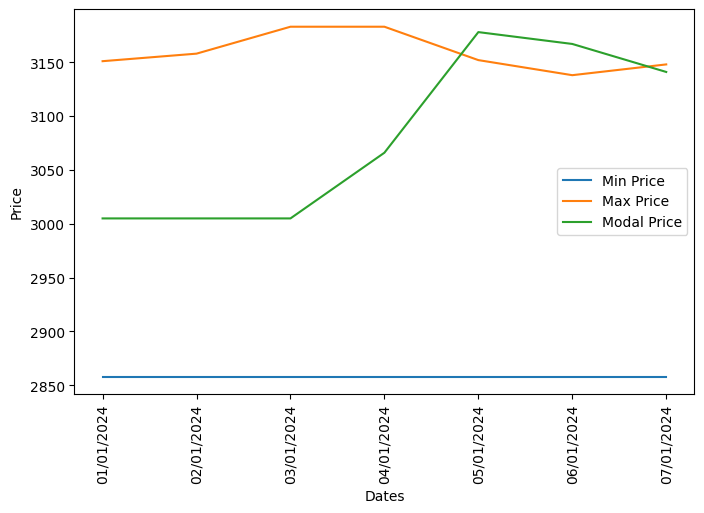

In [ ]:
# prompt: plot the previous dataframe where dates are the x axis x labels are write in vartical way plot the picture in (8,6) and y label should be price

import matplotlib.pyplot as plt
import seaborn as sns

# Create the plot
fig, ax = plt.subplots(figsize=(8, 5))

# Set the x-axis labels to be vertical
ax.tick_params(axis='x', rotation=90)

# Plot the data
sns.lineplot(data=df, x="Dates", y="Min Price", label="Min Price", ax=ax)
sns.lineplot(data=df, x="Dates", y="Max Price", label="Max Price", ax=ax)
sns.lineplot(data=df, x="Dates", y="Modal Price", label="Modal Price", ax=ax)

# Set the y-axis label
ax.set_ylabel("Price")

# Show the plot
plt.show()


make a plot with past data with upcoming predicted data

In [ ]:
price_min = price_min.reshape(-1,)
price_max = price_max.reshape(-1,)
price_mod = price_mod.reshape(-1,)

array([3100., 3100., 3100., 3100., 3100., 3100., 3100., 3100., 3100.,
       3100., 3100., 3100., 3100., 3100., 3100., 3100., 3100., 3100.,
       3100., 3100., 3100., 3100., 3100., 3100., 3100., 3100., 3100.,
       3100., 3100., 3100., 3100., 3100., 3100., 3100., 3100., 3000.,
       3000., 3000., 3000., 3000., 3000., 3000., 3000., 3000., 3000.,
       3000., 3000., 3000., 3000., 3000., 3000., 3000., 3000., 3000.,
       3000., 3000., 3000., 3000., 3000., 3000., 3000., 3000., 3000.,
       3000., 3000., 3000., 3000., 3000., 3000., 3000., 3000., 3000.,
       3000., 3000., 3000., 3000., 3000., 3000., 3000., 3000., 3000.,
       3000., 3000., 3000., 3000., 3000., 3000., 3000., 3000., 3000.,
       3000., 3000., 3000., 3000., 3000., 3000., 3000., 3000., 3000.,
       3000., 3000., 3000., 3000., 3000., 3000., 3000., 3000., 3000.,
       3000., 3000., 3000., 3000., 3000., 3000., 3000., 3000., 3000.,
       3000., 3000., 3000., 3000., 3000., 3000., 3000., 3000., 3000.,
       3000., 3000.,

In [ ]:

new_price_min = np.concatenate((price_min[-(token +21):-21], y_pred_min_list))
new_price_max = np.concatenate((price_max[-(token +21):-21], y_pred_max_list))
new_price_mod = np.concatenate((price_mod[-(token +21):-21], y_pred_mod_list))

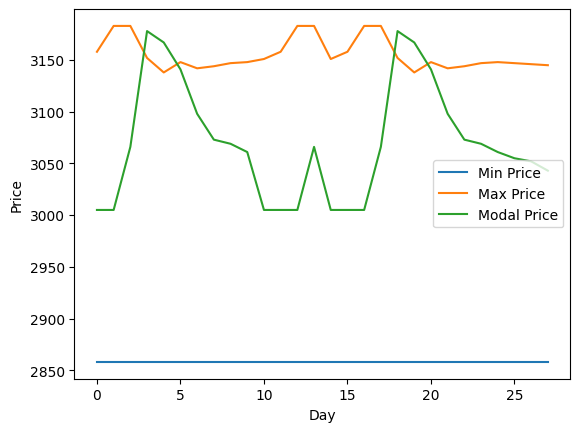

In [ ]:
#plot the predicted data with last 7 days data

import matplotlib.pyplot as plt
import numpy as np

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the last 7 data points of price_min, price_max, and price_mod
ax.plot(new_price_min, label="Min Price")
ax.plot(new_price_max, label="Max Price")
ax.plot(new_price_mod, label="Modal Price")

ax.legend()
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

